In [ ]:
import logging; logging.basicConfig(level=logging.INFO)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import logictensornetworks2 as ltn
import logictensornetworks2.fuzzy_ops as fuzzy_ops

# Data

In [ ]:
entities = ["sue", "diana", "john", "edna", "paul", "francis", "john2",
                "john3", "john4", "joe", "jennifer", "juliet", "janice",
                "joey", "tom", "bonnie", "katie"]

parents = [
        ("sue", "diana"),
        ("john", "diana"),
        ("sue", "bonnie"),
        ("john", "bonnie"),
        ("sue", "tom"),
        ("john", "tom"),
        ("diana", "katie"),
        ("paul", "katie"),
        ("edna", "sue"),
        ("john2", "sue"),
        ("edna", "john3"),
        ("john2", "john3"),
        ("francis", "john"),
        ("john4", "john"),
        ("francis", "janice"),
        ("john4", "janice"),
        ("janice", "jennifer"),
        ("joe", "jennifer"),
        ("janice", "juliet"),
        ("joe", "juliet"),
        ("janice", "joey"),
        ("joe", "joey")]

# LTN

Grounding

Note that the variables for the ancestors and children share the same `dom` attribute.  
This means that we can write `forall (ancestor, child) pairs: parent(ancestor,child)` to take the elements pair-wise (it is expected that the number of values in `ancestor` is the same as the number of values in `child`.

In [ ]:
embedding_size = 2

Ancestor = ltn.Predicate.MLP([embedding_size,embedding_size])
Parent = ltn.Predicate.MLP([embedding_size,embedding_size])

g_e = {
    l: ltn.constant(np.random.uniform(low=0.,high=1.,size=embedding_size), trainable=True) 
    for l in entities
}

g_a = []
g_c = []
for a, c in parents:
    g_a.append(g_e[a])
    g_c.append(g_e[c])    

Knowledge Base

In [ ]:
Not = ltn.Wrapper_ConnectiveOp(fuzzy_ops.Not_Std())
And = ltn.Wrapper_ConnectiveOp(fuzzy_ops.And_Luk())
Or = ltn.Wrapper_ConnectiveOp(fuzzy_ops.Or_Luk())
Implies = ltn.Wrapper_ConnectiveOp(fuzzy_ops.Implies_Luk())
# Forall = ltn.Wrapper_AggregationOp(ltn.fuzzy_ops.Aggreg_hMean())
Forall = ltn.experimental.Wrapper_AggregationOp(ltn.experimental.Aggreg_pMeanError(p=-1)) # for higher p, the forall is more strict

In [ ]:
formula_aggregator = ltn.fuzzy_ops.Aggreg_Min()

# defining the theory
@tf.function
@ltn.domains() # can be commented
def axioms():
    """ 
    NOTE: we update the embeddings at each step
        -> we should re-compute the variables.
    """
    a = ltn.variable("a",tf.stack(list(g_e.values())))
    b = ltn.variable("b",tf.stack(list(g_e.values())))
    c = ltn.variable("c",tf.stack(list(g_e.values())))

    axioms = [
        # forall pairs of (ancestor, child): Parent(ancestor,child)
        Parent([g_e[a],g_e[c]])
        for a,c in parents
    ] + \
    [
        # forall a,b: Parent(a,b) -> Ancestor(a,b) 
        Forall(ltn.bound(a,b), Implies(Parent([a,b]),Ancestor([a,b]))),
        # forall a: ~Parent(a,a)
        Forall(ltn.bound(a), Not(Parent([a,a]))),
        # forall a: ~Ancestor(a,a)
        Forall(ltn.bound(a), Not(Ancestor([a,a]))),
        # forall a,b: Parent(a,b) -> ~Parent(b,a)
        Forall(ltn.bound(a,b), Implies(Parent([a,b]),Not(Parent([b,a]))))
    ]    
    # computing sat_level
    axioms = tf.stack([tf.squeeze(ax) for ax in axioms])
    sat_level = formula_aggregator(axioms)
    return sat_level, axioms

Training

In [ ]:
trainable_variables = \
        Parent.trainable_variables\
        +Ancestor.trainable_variables \
        +list(g_e.values())
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
for epoch in range(1500):
    with tf.GradientTape() as tape:
        loss_value = 1. - axioms()[0]
    grads = tape.gradient(loss_value, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    if epoch%200 == 0:
        print("Epoch %d: Sat Level %.3f"%(epoch, axioms()[0]))
print("Training finished at Epoch %d with Sat Level %.3f"%(epoch, axioms()[0]))

Epoch 0: Sat Level 0.283
Epoch 200: Sat Level 0.499
Epoch 400: Sat Level 0.500
Epoch 600: Sat Level 0.504
Epoch 800: Sat Level 0.512
Epoch 1000: Sat Level 0.538
Epoch 1200: Sat Level 0.624
Epoch 1400: Sat Level 0.731
Training finished at Epoch 1499 with Sat Level 0.743


Additional axioms:
1. forall a,b,c: (Ancestor(a,b) & Parent(b,c)) -> Ancestor (a,c)
2. forall a,b: Ancestor(a,b) -> ~Ancestor(b,a)
3. forall a,b,c: (Parent(a,b) & Parent(b,c)) -> Ancestor(a,c)
4. forall a,b,c: (Ancestor(a,b) & Ancestor(b,c)) -> Ancestor(a,c)

In [ ]:
a = ltn.variable("a",tf.stack(list(g_e.values())))
b = ltn.variable("b",tf.stack(list(g_e.values())))
c = ltn.variable("c",tf.stack(list(g_e.values())))
d = ltn.variable("c",tf.stack(list(g_e.values())))

In [ ]:
Forall(ltn.bound(a,b), 
       Implies(Ancestor([a,b]), Not(Ancestor([b,a])))
)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9999899>

In [ ]:
Forall(ltn.bound(a,b,c),
       Implies(And(Parent([a,b]),Parent([b,c])), Ancestor([a,c]))
)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9999872>

In [ ]:
Forall(ltn.bound(a,b), Implies(Parent([a,b]),Not(Parent([b,a]))))

<tf.Tensor: shape=(), dtype=float32, numpy=0.99999>

In [ ]:
Forall(ltn.bound(a,b), Implies(Ancestor([a,b]),Not(Ancestor([b,a]))))

<tf.Tensor: shape=(), dtype=float32, numpy=0.9999899>

In [ ]:
@tf.function
@ltn.domains() # can be commented
def new_axioms():
    """ 
    NOTE: we update the embeddings at each step
        -> we should re-compute the variables.
    """
    a = ltn.variable("a",tf.stack(list(g_e.values())))
    b = ltn.variable("b",tf.stack(list(g_e.values())))
    c = ltn.variable("c",tf.stack(list(g_e.values())))

    axioms = [
        # forall pairs of (ancestor, child): Parent(ancestor,child)
        Parent([g_e[a],g_e[c]])
        for a,c in parents
    ] + \
    [
        # forall a,b: Parent(a,b) -> Ancestor(a,b) 
        Forall(ltn.bound(a,b), Implies(Parent([a,b]),Ancestor([a,b]))),
        # forall a: ~Parent(a,a)
        Forall(ltn.bound(a), Not(Parent([a,a]))),
        # forall a: ~Ancestor(a,a)
        Forall(ltn.bound(a), Not(Ancestor([a,a]))),
        # forall a,b: Parent(a,b) -> ~Parent(b,a)
        Forall(ltn.bound(a,b), Implies(Parent([a,b]),Not(Parent([b,a])))),
        Forall(ltn.bound(a,b,c), Implies(And(Ancestor([a,b]),Parent([b,c])), Ancestor([a,c]))),
        Forall(ltn.bound(a,b), Implies(Ancestor([a,b]), Not(Ancestor([b,a])))),
        Forall(ltn.bound(a,b,c),Implies(And(Parent([a,b]),Parent([b,c])), Ancestor([a,c]))),
        Forall(ltn.bound(a,b,c),Implies(And(Parent([a,b]),Parent([b,c])), Ancestor([a,c])))
    ]    
    # computing sat_level
    axioms = tf.stack([tf.squeeze(ax) for ax in axioms])
    sat_level = formula_aggregator(axioms)
    return sat_level, axioms

In [ ]:
for epoch in range(3000):
    with tf.GradientTape() as tape:
        loss_value = 1. - new_axioms()[0]
    grads = tape.gradient(loss_value, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    if epoch%200 == 0:
        print("Epoch %d: Sat Level %.3f"%(epoch, new_axioms()[0]))
print("Training finished at Epoch %d with Sat Level %.3f"%(epoch, new_axioms()[0]))

Epoch 0: Sat Level 0.931
Epoch 200: Sat Level 0.973
Epoch 400: Sat Level 0.987
Epoch 600: Sat Level 0.992
Epoch 800: Sat Level 0.995
Epoch 1000: Sat Level 0.997
Epoch 1200: Sat Level 0.998
Epoch 1400: Sat Level 0.998
Epoch 1600: Sat Level 0.999
Epoch 1800: Sat Level 0.999
Epoch 2000: Sat Level 0.999
Epoch 2200: Sat Level 0.999
Epoch 2400: Sat Level 0.999
Epoch 2600: Sat Level 0.999
Epoch 2800: Sat Level 1.000
Training finished at Epoch 2999 with Sat Level 1.000


In [ ]:
for epoch in range(2000):
    with tf.GradientTape() as tape:
        loss_value = 1. - new_axioms()[0]
    grads = tape.gradient(loss_value, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    if epoch%200 == 0:
        print("Epoch %d: Sat Level %.3f"%(epoch, new_axioms()[0]))
print("Training finished at Epoch %d with Sat Level %.3f"%(epoch, new_axioms()[0]))

Epoch 0: Sat Level 0.998
Epoch 200: Sat Level 0.999
Epoch 400: Sat Level 0.999
Epoch 600: Sat Level 0.999
Epoch 800: Sat Level 0.999
Epoch 1000: Sat Level 0.999
Epoch 1200: Sat Level 0.999
Epoch 1400: Sat Level 1.000
Epoch 1600: Sat Level 1.000
Epoch 1800: Sat Level 1.000
Training finished at Epoch 1999 with Sat Level 1.000


In [1]:
# !apt install libgraphviz-dev
# !pip install pygraphviz

In [ ]:
import networkx as nx

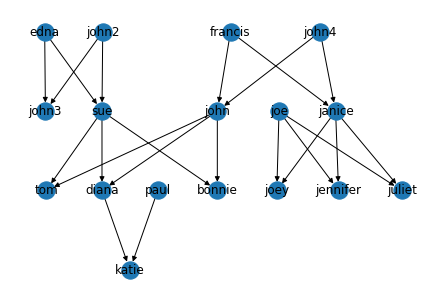

In [ ]:
# Ground Truth Parents
parDG_truth = nx.DiGraph(parents)
pos= nx.drawing.nx_agraph.graphviz_layout(parDG_truth, prog='dot')
nx.draw(parDG_truth,pos,with_labels=True)

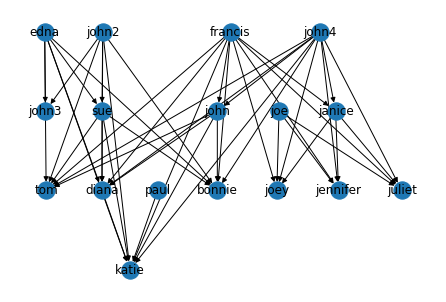

In [ ]:
def get_descendants(entity, DG):
    all_d = []
    direct_d = list(DG.successors(entity))
    all_d += direct_d
    for d in direct_d:
        all_d += get_descendants(d, DG)
    return all_d

ancestors = []
for e in entities:
    for d in get_descendants(e, parDG_truth):
        ancestors.append((e,d))

ancDG_truth = nx.DiGraph(ancestors)
pos= nx.drawing.nx_agraph.graphviz_layout(parDG_truth, prog='dot')
nx.draw(ancDG_truth,pos,with_labels=True)

In [ ]:
embedding_size = 2

Ancestor = ltn.Predicate.MLP([embedding_size,embedding_size])
Parent = ltn.Predicate.MLP([embedding_size,embedding_size])

g_e = {
    l: ltn.constant(np.random.uniform(low=0.,high=1.,size=embedding_size), trainable=True) 
    for l in entities
}

g_p = []
g_c = []
for p, c in parents:
    g_p.append(g_e[p])
    g_c.append(g_e[c])

In [ ]:
Not = ltn.Wrapper_ConnectiveOp(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_ConnectiveOp(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_ConnectiveOp(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_ConnectiveOp(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.experimental.Wrapper_AggregationOp(ltn.experimental.Aggreg_pMeanError(p=5))

In [ ]:
formula_aggregator = ltn.fuzzy_ops.Aggreg_pMeanError(p=5)

# lambda operators that take in two groundings 
# and return if they are equal or different
same_g = lambda x,y: tf.reduce_all(tf.equal(x,y),axis=-1)
differ_g = lambda x,y: tf.logical_not(same_g(x,y))

# defining the theory
@tf.function
@ltn.domains() # can be commented
def newer_axioms():
    """ 
    NOTE: we update the embeddings at each step
        -> we should re-compute the variables.
    """
    parent = ltn.variable(dom="parents_pairs",feed=tf.stack(g_p))
    child = ltn.variable(dom="parents_pairs",feed=tf.stack(g_c))
    a = ltn.variable("a",tf.stack(list(g_e.values())))
    b = ltn.variable("b",tf.stack(list(g_e.values())))
    c = ltn.variable("c",tf.stack(list(g_e.values())))
    d = ltn.variable("d",tf.stack(list(g_e.values())))

    axioms = [
        # forall pairs of (ancestor, child): Parent(ancestor,child)
        Forall(ltn.bound(parent,child), Parent([parent,child])),
        # forall a,b: Parent(a,b) -> Ancestor(a,b) 
        Forall(ltn.bound(a,b), Implies(Parent([a,b]),Ancestor([a,b]))),
        # forall a: ~Parent(a,a)
        Forall(ltn.bound(a), Not(Parent([a,a]))),
        # forall a: ~Ancestor(a,a)
        Forall(ltn.bound(a), Not(Ancestor([a,a]))),
        # forall a,b: Parent(a,b) -> ~Parent(b,a)
        Forall(ltn.bound(a,b), Implies(Parent([a,b]),Not(Parent([b,a])))),
        # forall a,b,c,d : parent(b,a) and parent(c,a) -> not parent(d,a)
        Forall(
            ltn.bound(a,b,c,d),
            Implies(And(Parent([b,a]),Parent([c,a])), Not(Parent([d,a]))),
            mask_vars=[a,b,c,d],
            mask_fn=lambda vars: tf.reduce_all(
                (differ_g(vars[0],vars[1]),differ_g(vars[0],vars[2]),differ_g(vars[0],vars[3]),
                 differ_g(vars[1],vars[2]),differ_g(vars[1],vars[3]),differ_g(vars[2],vars[3])),
                axis=0
            )
        )
    ]    
    # computing sat_level
    axioms = tf.stack([tf.squeeze(ax) for ax in axioms])
    sat_level = formula_aggregator(axioms)
    return sat_level, axioms

In [ ]:
trainable_variables = \
        Parent.trainable_variables\
        +Ancestor.trainable_variables \
        +list(g_e.values())
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
for epoch in range(3000):
    with tf.GradientTape() as tape:
        loss_value = 1. - newer_axioms()[0]
    grads = tape.gradient(loss_value, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    if epoch%200 == 0:
        print("Epoch %d: Sat Level %.3f"%(epoch, newer_axioms()[0]))
print("Training finished at Epoch %d with Sat Level %.3f"%(epoch, newer_axioms()[0]))

Epoch 0: Sat Level 0.566
Epoch 200: Sat Level 0.648
Epoch 400: Sat Level 0.774
Epoch 600: Sat Level 0.835
Epoch 800: Sat Level 0.891
Epoch 1000: Sat Level 0.995
Epoch 1200: Sat Level 0.999
Epoch 1400: Sat Level 0.999
Epoch 1600: Sat Level 1.000
Epoch 1800: Sat Level 1.000
Epoch 2000: Sat Level 1.000
Epoch 2200: Sat Level 1.000
Epoch 2400: Sat Level 1.000
Epoch 2600: Sat Level 1.000
Epoch 2800: Sat Level 1.000
Training finished at Epoch 2999 with Sat Level 1.000


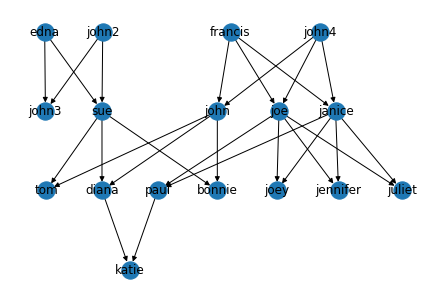

In [ ]:
threshold = 0.5
parents_test = [
    (e1,e2) for e1 in entities for e2 in entities
    if (Parent([g_e[e1],g_e[e2]]).numpy() > 0.5)
]

parDG_test = nx.DiGraph(parents_test)
pos= nx.drawing.nx_agraph.graphviz_layout(parDG_truth, prog='dot')
nx.draw(parDG_test,pos,with_labels=True)

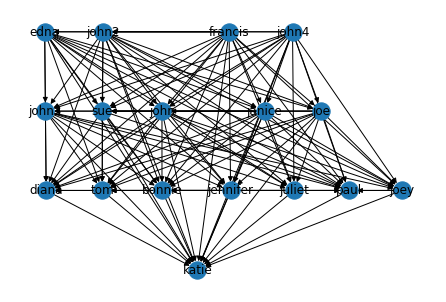

In [ ]:
threshold = 0.5
ancestors_test = [
    (e1,e2) for e1 in entities for e2 in entities
    if (Ancestor([g_e[e1],g_e[e2]]).numpy() > 0.5)
]

ancDG_test = nx.DiGraph(ancestors_test)
pos= nx.drawing.nx_agraph.graphviz_layout(parDG_test, prog='dot')
nx.draw(ancDG_test,pos,with_labels=True)

In [ ]:
a = ltn.variable("a",tf.stack(list(g_e.values())))
b = ltn.variable("b",tf.stack(list(g_e.values())))
c = ltn.variable("c",tf.stack(list(g_e.values())))
d = ltn.variable("c",tf.stack(list(g_e.values())))

In [ ]:
Forall(
            ltn.bound(a,b,c),
            Implies(And(Parent([a,b]),Not(Parent([b,c]))), Not(Ancestor([a,c])))
        )

<tf.Tensor: shape=(), dtype=float32, numpy=0.46134734>

In [ ]:
trainable_variables = \
        Parent.trainable_variables\
        +Ancestor.trainable_variables \
        +list(g_e.values())
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
formula_aggregator = ltn.fuzzy_ops.Aggreg_pMeanError(p=2)
same_g = lambda x,y: tf.reduce_all(tf.equal(x,y),axis=-1)
differ_g = lambda x,y: tf.logical_not(same_g(x,y))

@tf.function
@ltn.domains() # can be commented
def newer_axioms():
    """ 
    NOTE: we update the embeddings at each step
        -> we should re-compute the variables.
    """
    parent = ltn.variable(dom="parents_pairs",feed=tf.stack(g_p))
    child = ltn.variable(dom="parents_pairs",feed=tf.stack(g_c))
    a = ltn.variable("a",tf.stack(list(g_e.values())))
    b = ltn.variable("b",tf.stack(list(g_e.values())))
    c = ltn.variable("c",tf.stack(list(g_e.values())))
    d = ltn.variable("d",tf.stack(list(g_e.values())))

    axioms = [
        # forall pairs of (ancestor, child): Parent(ancestor,child)
        Forall(ltn.bound(parent,child), Parent([parent,child])),
        # forall a,b: Parent(a,b) -> Ancestor(a,b) 
        Forall(ltn.bound(a,b), Implies(Parent([a,b]),Ancestor([a,b]))),
        # forall a: ~Parent(a,a)
        Forall(ltn.bound(a), Not(Parent([a,a]))),
        # forall a: ~Ancestor(a,a)
        Forall(ltn.bound(a), Not(Ancestor([a,a]))),
        # forall a,b: Parent(a,b) -> ~Parent(b,a)
        Forall(ltn.bound(a,b), Implies(Parent([a,b]),Not(Parent([b,a])))),
        # forall a,b,c,d : parent(b,a) and parent(c,a) -> not parent(d,a)
        Forall(
            ltn.bound(a,b,c,d),
            Implies(And(Parent([b,a]),Parent([c,a])), Not(Parent([d,a]))),
            mask_vars=[a,b,c,d],
            mask_fn=lambda vars: tf.reduce_all(
                (differ_g(vars[0],vars[1]),differ_g(vars[0],vars[2]),differ_g(vars[0],vars[3]),
                 differ_g(vars[1],vars[2]),differ_g(vars[1],vars[3]),differ_g(vars[2],vars[3])),
                axis=0
            )
        ),
        Forall(
            ltn.bound(a,b),
            Implies(Ancestor([a,b]),Not(Ancestor([b,a])))
        ),

        Forall(ltn.bound(a,b,c),
       Implies(And(Parent([a,b]),Parent([b,c])), Ancestor([a,c]))
        ),

        Forall(
            ltn.bound(a,b,c),
            Implies(And(Not(Parent([a,b])),Parent([b,c])), Not(Ancestor([a,c]))),
            mask_vars=[a,b,c],
            mask_fn=lambda vars: tf.reduce_all(
                (differ_g(vars[0],vars[1]),differ_g(vars[0],vars[2]),differ_g(vars[1],vars[2])),
                axis=0
                 )
        ) 
        
    ]    
    # computing sat_level
    axioms = tf.stack([tf.squeeze(ax) for ax in axioms])
    sat_level = formula_aggregator(axioms)
    return sat_level, axioms

In [ ]:
for epoch in range(4000):
    with tf.GradientTape() as tape:
        loss_value = 1. - newer_axioms()[0]
    grads = tape.gradient(loss_value, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    if epoch%200 == 0:
        print("Epoch %d: Sat Level %.3f"%(epoch, newer_axioms()[0]))
print("Training finished at Epoch %d with Sat Level %.3f"%(epoch, newer_axioms()[0]))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to identify source code of lambda function <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__newer_axioms.<locals>.<lambda> at 0x7fc3601f0f28>. It was defined on this line: axioms = [ag__.converted_call(Forall, (ag__.converted_call(ltn.bound, (parent, child), None, fscope), ag__.converted_call(Parent, ([parent, child],), None, fscope)), None, fscope), ag__.converted_call(Forall, (ag__.converted_call(ltn.bound, (a, b), None, fscope), ag__.converted_call(Implies, (ag__.converted_call(Parent, ([a, b],), None, fscope), ag__.converted_call(Ancestor, ([a, b],), None, fscope)), None, fscope)), None, fscope), ag__.converted_call(Forall, (ag__.converted_call(ltn.bound, (a,), None, fscope), ag__.converted_call(Not, (ag__.converted_call(Parent, ([a, a],), None, fscope),), None, fscope)), 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to identify source code of lambda function <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__newer_axioms.<locals>.<lambda> at 0x7fc3601f0f28>. It was defined on this line: axioms = [ag__.converted_call(Forall, (ag__.converted_call(ltn.bound, (parent, child), None, fscope), ag__.converted_call(Parent, ([parent, child],), None, fscope)), None, fscope), ag__.converted_call(Forall, (ag__.converted_call(ltn.bound, (a, b), None, fscope), ag__.converted_call(Implies, (ag__.converted_call(Parent, ([a, b],), None, fscope), ag__.converted_call(Ancestor, ([a, b],), None, fscope)), None, fscope)), None, fscope), ag__.converted_call(Forall, (ag__.converted_call(ltn.bound, (a,), None, fscope), ag__.converted_call(Not, (ag__.converted_call(Parent, ([a, a],), None, fscope),), None, fscope)), 

In [ ]:
newer_axioms()[1].numpy()

array([0.8955344 , 0.88001657, 0.99996233, 0.99934775, 0.99999   ,
       0.97722566, 0.99999   , 0.92214376, 0.74339855], dtype=float32)

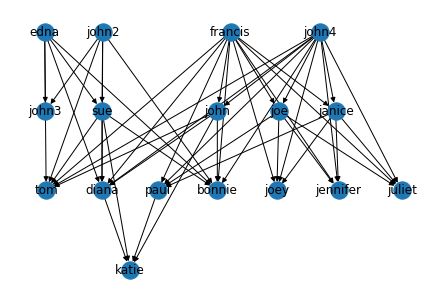

In [ ]:
threshold = 0.5
ancestors_test = [
    (e1,e2) for e1 in entities for e2 in entities
    if (Ancestor([g_e[e1],g_e[e2]]).numpy() > 0.5)
]

ancDG_test = nx.DiGraph(ancestors_test)
pos= nx.drawing.nx_agraph.graphviz_layout(parDG_truth, prog='dot')
nx.draw(ancDG_test,pos,with_labels=True)

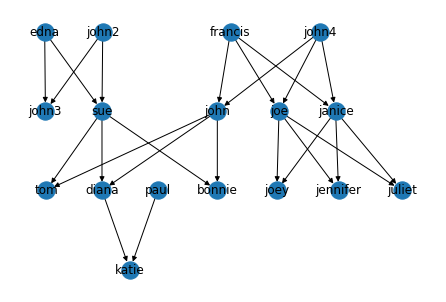

In [ ]:
threshold = 0.5
parents_test = [
    (e1,e2) for e1 in entities for e2 in entities
    if (Parent([g_e[e1],g_e[e2]]).numpy() > 0.5)
]

parDG_test = nx.DiGraph(parents_test)
pos= nx.drawing.nx_agraph.graphviz_layout(parDG_truth, prog='dot')
nx.draw(parDG_test,pos,with_labels=True)

Some evaluation using Bianchi github repo
https://github.com/vinid/ltns-experiments

In [ ]:
import itertools
all_relationships = list(itertools.product(entities, repeat=2))

In [ ]:
with open("ancestorres", "w") as resutls_file:
    resutls_file.write("Test" + "\n")
    logging.info("Inferencing Ancestors")
    for a,b in all_relationships:
        resutls_file.write(a + "," + b + "," + str(Ancestor([g_e[a],g_e[b]]).numpy()) + "\n")

INFO:root:Inferencing Ancestors


In [ ]:
from sklearn.metrics import matthews_corrcoef, f1_score, precision_score, recall_score, accuracy_score
import pandas as pd


def compute_all_values(gold_standard, prediction_file, kb, use_kb=True, use_only_kb=False):
    """
    Compute performance measures
    :param gold_standard: csv to be loaded into a pd.DataFrame
    :param prediction_file: csv to be loaded into a pd.DataFrame
    :param kb:
    :param use_kb:
    :param use_only_kb:
    :return:
    """
    closed = pd.read_csv(gold_standard, names=["first", "second", "type"])
    testing = pd.read_csv(prediction_file, skiprows=[0], names=["first", "second", "type"])

    data = pd.merge(closed, testing, on=["first", "second"])

    zipped_data = []
    if not use_kb:
        for index, row in data.iterrows():
            if (row["first"], row["second"]) in kb:
                continue
            else:
                zipped_data.append((row["type_x"], row["type_y"]))
    else:
        zipped_data = zip(data["type_x"].values.tolist(), data["type_y"].values.tolist())

    if use_only_kb:
        zipped_data = []
        for index, row in data.iterrows():
            if (row["first"], row["second"]) not in kb:
                continue
            else:
                zipped_data.append((row["type_x"], row["type_y"]))
    mae = 0
    for a, b in zipped_data:
        mae = mae + abs(a - b)
    print(len(list(zipped_data)))
    print(data["type_x"].values.size)

    # mae = mae / float(len(zipped_data))
    mae = mae / float(data["type_x"].values.size)

    y_actual = list(map(lambda x: x[0], zipped_data))
    y_hat = list(map(lambda x: int(lucky_round(x)), map(lambda x: x[1], zipped_data)))

    tp, fp, tn, fn = perf_measure(y_actual, y_hat)
    return {"mae": mae, "matthews": matthews_corrcoef(y_actual, y_hat), "f1": f1_score(y_actual, y_hat),
            "precision": precision_score(y_actual, y_hat), "recall": recall_score(y_actual, y_hat),
            "tp": tp, "fp": fp, "tn": tn, "fn": fn, "accuracy_score": accuracy_score(y_actual, y_hat)}

def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(289):
        if y_actual[i] == y_hat[i] == 1:
            TP += 1
        if y_hat[i] == 1 and y_actual[i] != y_hat[i]:
            FP += 1
        if y_actual[i] == y_hat[i] == 0:
            TN += 1
        if y_hat[i] == 0 and y_actual[i] != y_hat[i]:
            FN += 1

    return (TP, FP, TN, FN)


def lucky_round(val, hold=0.5):
    if val >= hold:
        return 1
    else:
        return 0

In [ ]:
# !git clone https://github.com/vinid/ltns-experiments.git

In [ ]:
closed = pd.read_csv("/content/ltns-experiments/experiments/gold_standard/closed_an", names=["first", "second", "type"])
testing = pd.read_csv("ancestorres", skiprows=[0], names=["first", "second", "type"])

data = pd.merge(closed, testing, on=["first", "second"])

In [ ]:
y_actual = data['type_x']
y_hat = [round(x,0) for x in data['type_y']]

tp, fp, tn, fn = perf_measure(y_actual, y_hat)

In [ ]:
tra = zip(data["type_x"].values.tolist(), data["type_y"].values.tolist())

In [ ]:
mae = 0
for a, b in tra:
  mae = mae + abs(a - b)
mae = mae / float(data["type_x"].values.size)

In [ ]:
print("mae",mae,"matthews",matthews_corrcoef(y_actual, y_hat),"f1",f1_score(y_actual, y_hat),"precision", precision_score(y_actual, y_hat), "recall", recall_score(y_actual, y_hat))

mae 0.08165908517612086 matthews 0.8512180278879768 f1 0.8749999999999999 precision 0.84 recall 0.9130434782608695
